# Proyecto análisis numérico: Búsqueda de raíces mediante el cálculo de valores propios de matrices colega

#### Integrantes: Andrés Hernández Vargas, Francisco Javier Díaz Perdomo  y Joaquin Peñuela Parra

In [1]:
# Primero importamos las librerías que utilizaremos
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy as sym
import scipy.integrate
import scipy.special

## 1. Búsqueda de valores propios de matriz colega

##### Teorema:

Sea $p(x)$ un polinomio tal que:
$$
p(x)=\sum_{k=0}^{n} a_{k} T_{k}(x), \quad a_{n} \neq 0
$$
Entonces sus raíces son los valores propios de la matriz: 

$$
C=\left(\begin{array}{cccccc}
0 & 1 & & & & \\
\frac{1}{2} & 0 & \frac{1}{2} & & & \\
& \frac{1}{2} & 0 & \frac{1}{2} & & \\
& & \ddots & \ddots & \ddots & \\
& & & & & \frac{1}{2} \\
& & & & \frac{1}{2} & 0
\end{array}\right)-\frac{1}{2 a_{n}}\left(\begin{array}{lllll} 
& & & & & & & \\
& & & & & & & \\
& & & & & & & \\
a_{0} & a_{1} & a_{2} & \ldots & a_{n-1}
\end{array}\right)
$$ 

(Entradas vacías son cero.) En el caso en que hayan raíces iguales, estas corresponderán a valores propios que tengan la misma multiplicidad que la cantidad de raíces.

##### Nota: Para los polinomios que solo tengan raíces reales es suficiente usar la iteración QR vista en clase para el cálculo de los valores propios. No obstante, para obtener las soluciones en el plano complejo es necesario recurrir al método de numpy linalg.eig().

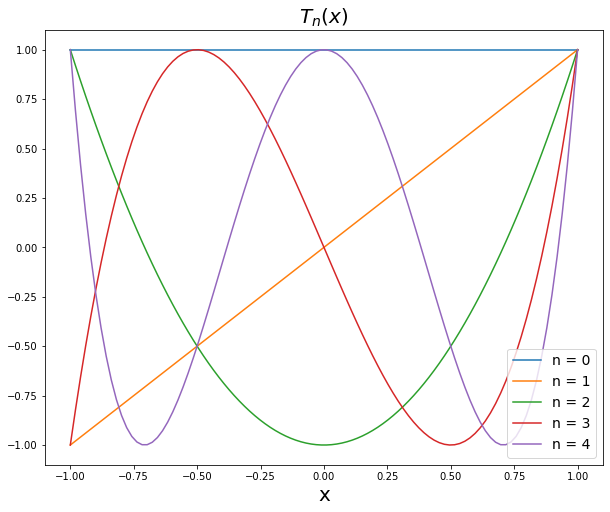

In [2]:
#Primero grafiquemos algunos de los polinomios de chebyshev 
#para probar como se hace

fig = plt.figure(figsize = (10,8))

x = np.linspace(-1,1,100)
for i in range(5):
    coef = np.zeros(5)
    coef[i] = 1
    f = np.polynomial.chebyshev.Chebyshev(coef)
    etiqueta = "n = " + str(i)
    plt.plot(x,f(x), label = etiqueta)
plt.title(r'$T_{n}(x)$',fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

In [3]:
# Primero definimos una función que nos retorna la matriz C_n dados los coeficientes a_i
def C_Matrix(coeficientes):
    #Coeficientes es de la forma [a0, a1, a2, ..., an] y an != 0
    n = len(coeficientes) - 1
    C = np.zeros((n,n))
    C[1,0] = 1/2
    C[0,1] = 1
    for i in range(1,n-1):            
        C[i+1,i] = 1/2
        C[i,i+1] = 1/2
    for j in range(n):
        C[n-1,j] = C[n-1,j] - coeficientes[j]/(2*coeficientes[n])
    return C

#La idea será calcular los valores propios de esta matriz, así que implementemos la iteración QR para calcularlos.

#Función que retorna la norma del vector de entrada.
def norm_vec(vector):
    suma = 0
    for i in range(len(vector)):
        suma = suma + vector[i]**2
    return np.sqrt(suma)
    
# Definimos una función que nos retorna la factorización QR de una matriz A utilizando reflectores de Householder.
def QR(Matrix):    
    Q = np.eye(len(Matrix[:,0]))           

    for i in range(len(Matrix[:,0])):          
        a_i = Matrix[i:,i]
         
        e_i = np.zeros(len(a_i))
        e_i[0] = 1
        u_i = a_i - e_i*norm_vec(a_i)
        v_i = u_i/norm_vec(u_i)
        F = np.eye(len(v_i)) - 2*np.outer(v_i,v_i)
        
        Q_i = np.eye(len(Matrix[:,0]))
        Q_i[i:, i:] = F
        Matrix = Q_i@Matrix# Si funciona
        Q = np.dot(Q,np.transpose(Q_i))
    R = Matrix
    return Q, R

# Función que calcula los valores propios utilizando la iteración QR
def V_Propios(A, N = 20000):

    Q, R = QR(A)
    A_i = np.dot(R,Q)
    for i in range(N):
        Q, R = QR(A_i)
        A_i = np.dot(R, Q)
        
    Valores = np.array([])
    for i in range(len(A_i)):
        Valores = np.append(Valores, A_i[i,i])
    return Valores

#Cálculo de raíces usando la iteración QR - Funciones con raíces reales.
def Raices(coefs):
    CT = C_Matrix(coefs) 
    return V_Propios(CT)

#Cálculo de raíces usando el método de python - Incluye las del plano complejo.
def Raices_Python(coefs):
    CT = C_Matrix(coefs) 
    valores, vectores = np.linalg.eig(CT)
    return valores

A continuación, probamos el método implementado para ver si realmente funciona.

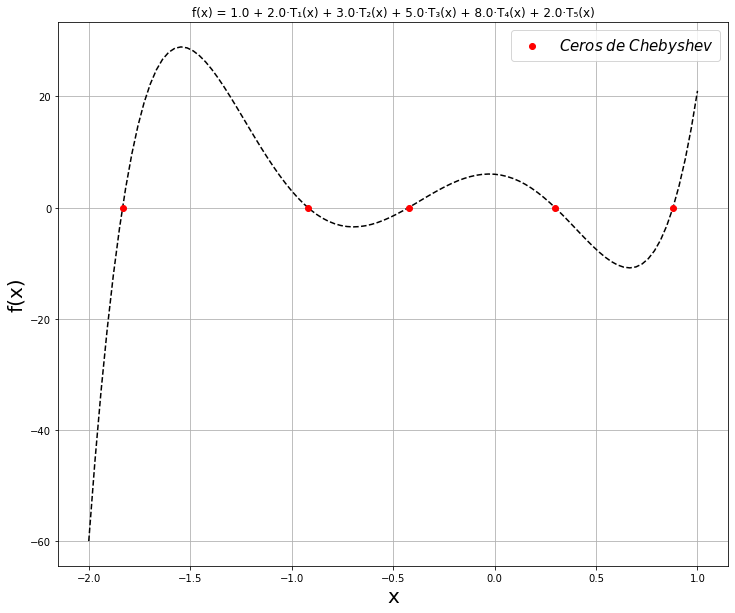

In [4]:
#Ahora analicemos una combinación lineal de ellos como lo plantea el teorema

fig = plt.figure(figsize = (12,10))

# Tomamos un polinomio expresado en base de Chebyshev y lo graficamos
x = np.linspace(-2,1,100)
cf_prueba = np.array([1,2,3,5,8,2])
f_prueba = np.polynomial.chebyshev.Chebyshev(cf_prueba)
plt.plot(x, f_prueba(x), '--', c = "black")

#Ahora calculemos las raices utilizando los métodos implementados y las graficamos.
raices = Raices(cf_prueba)

plt.scatter(raices, f_prueba(raices), c = "red", zorder = 20, label = "$Ceros\; de \; Chebyshev $")
plt.title("f(x) = " + str(f_prueba))
plt.ylabel("f(x)", fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.grid()
plt.legend(fontsize = 15)

## 2. Interpolación 

En este punto se puede ver que el teorema funciona. Sin embargo, aún es necesario como se haría para obtener la serie de Chebyshev para un polinomio o función arbitraria (no necesariamente en base de Chebyshev).

Para esto hay tenemos varias alternativas:

### 2.1 Proyección respecto a la base de Chebyshev

Utilizando la ortogonalidad de los polinomios de Chebyshev:

$$\int_{-1}^{1} T_{n}(x) T_{m}(x) \frac{d x}{\sqrt{1-x^{2}}}=\left\{\begin{array}{cl} 0 & : n \neq m \\ \pi & : n=m=0 \\ \pi / 2 & : n=m \neq 0 \end{array}\right. $$

In [5]:
# Definimos la función que aparece en la integral.
f3 = lambda x: 1/np.sqrt(1 - x**2) 

# Ahora definimos el producto interno que utilizaremos.
# Cabe notar, que la integral es calculada utilizando la regla del trapecio.
def prod_int1(f1,f2, N = 100000):
    Delta = (2)/N
    x_i = np.linspace(-1 + 5/N,1 - 5/N,N+1)
    # f tiene que ser una función vectorizada
    fx_i = f1(x_i)*f2(x_i)*f3(x_i)
    area = np.sum(fx_i[1:])*Delta #el 1 quita el primer elemento, queremos el extremo derecho
    return area

In [6]:
#Verificamos la ortogonalidad para este método.
N = 10
for i in range(1,N):
    coef1 = np.zeros(N)
    coef1[i-1] = 1
    f1 = np.polynomial.chebyshev.Chebyshev(coef1)
    coef2 = np.zeros(N)
    coef2[i] = 1
    f2 = np.polynomial.chebyshev.Chebyshev(coef2)
    mensaje = "<T_" + str(i-1) + "|T_" + str(i) + "> ="
    print(mensaje, prod_int1(f1,f2))
for i in range(N):
    coef1 = np.zeros(N)
    coef1[i] = 1
    f1 = np.polynomial.chebyshev.Chebyshev(coef1)
    mensaje = "<T_" + str(i) + "|T_" + str(i) + "> ="
    print(mensaje, prod_int1(f1,f1))

<T_0|T_1> = 0.0019999249992131447
<T_1|T_2> = 0.001999525024213035
<T_2|T_3> = 0.0019987252341985735
<T_3|T_4> = 0.0019975259490778627
<T_4|T_5> = 0.0019959276485528974
<T_5|T_6> = 0.0019939309719283487
<T_6|T_7> = 0.001991536717854397
<T_7|T_8> = 0.0019887458440087723
<T_8|T_9> = 0.001985559466713421
<T_0|T_0> = 3.1218146889764222
<T_1|T_1> = 1.5509404917861596
<T_2|T_2> = 1.550942511662632
<T_3|T_3> = 1.5509458775634446
<T_4|T_4> = 1.5509505886488104
<T_5|T_5> = 1.5509566437433886
<T_6|T_6> = 1.5509640413366363
<T_7|T_7> = 1.5509727795832706
<T_8|T_8> = 1.5509828563038284
<T_9|T_9> = 1.5509942689853264


In [7]:
# Definimos la función que aparece en la integral.
f3 = lambda x: 1/np.sqrt(1 - x**2) 

# Ahora definimos el producto interno que utilizaremos.
# Cabe notar, que la integral es calculada utilizando la regla del trapecio.
def prod_int2(f1,f2, N = 100000):
    area = scipy.integrate.quadrature(lambda x: f1(x)*f2(x)*f3(x), -1, 1)
    return area

In [8]:
#Verificamos la ortogonalidad para este método
N = 10
for i in range(1,N):
    coef1 = np.zeros(N)
    coef1[i-1] = 1
    f1 = np.polynomial.chebyshev.Chebyshev(coef1)
    coef2 = np.zeros(N)
    coef2[i] = 1
    f2 = np.polynomial.chebyshev.Chebyshev(coef2)
    mensaje = "<T_" + str(i-1) + "|T_" + str(i) + "> ="
    print(mensaje, prod_int2(f1,f2))
for i in range(N):
    coef1 = np.zeros(N)
    coef1[i] = 1
    f1 = np.polynomial.chebyshev.Chebyshev(coef1)
    mensaje = "<T_" + str(i) + "|T_" + str(i) + "> ="
    print(mensaje, prod_int2(f1,f1))

<T_0|T_1> = (0.0, 0.0)
<T_1|T_2> = (0.0, 0.0)
<T_2|T_3> = (0.0, 0.0)
<T_3|T_4> = (0.0, 0.0)
<T_4|T_5> = (0.0, 0.0)
<T_5|T_6> = (0.0, 0.0)
<T_6|T_7> = (0.0, 0.0)
<T_7|T_8> = (0.0, 0.0)
<T_8|T_9> = (0.0, 0.0)
<T_0|T_0> = (3.1071104393880544, 0.0006965869356871934)
<T_1|T_1> = (1.5363077148573239, 0.0006969826655747191)
<T_2|T_2> = (1.5362884894905768, 0.0006981732404169882)
<T_3|T_3> = (1.536256339619712, 0.0007001688752972246)
<T_4|T_4> = (1.5362111024624088, 0.000702986795528826)
<T_5|T_5> = (1.5361525473051152, 0.0007066515432210263)
<T_6|T_6> = (1.536080372607653, 0.0007111954192835501)
<T_7|T_7> = (1.5359942021673008, 0.0007166590744147605)
<T_8|T_8> = (1.5358935802516904, 0.0007230922675742768)
<T_9|T_9> = (1.535777965582971, 0.0007305548161422593)


/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.965869e-04
  warnings.warn(
/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.969827e-04
  warnings.warn(
/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.981732e-04
  warnings.warn(
/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001689e-04
  warnings.warn(
/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.029868e-04
  warnings.warn(
/home/pachodp13/miniconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: Accu

Denotando la representación de Chebyshev de la forma: $p(x) = \sum_{k} a_{k} T_{k}(x)$ los coefiecientes están dados simplemente por la proyección de la forma:

$$a_{k} = \frac{2}{\pi} \int_{-1}^{1} f(x) T_{k}(x) \frac{d x}{\sqrt{1-x^{2}}}$$

In [9]:
# Definimos la función que nos arroja los coeficientes en la base de Chebyshev a partir de los coeficientes en la base de monomios.
def proyectar(P_coef):
    p = np.polynomial.Polynomial(P_coef)
    rango = len(p)
    coeficientes = np.array([])
    for i in range(rango):
        coef_T = np.zeros(rango)
        coef_T[i] = 1
        T_i = np.polynomial.chebyshev.Chebyshev(coef_T)
        a_i = prod_int1(p,T_i)*2/np.pi
        coeficientes = np.append(coeficientes, a_i)
    coeficientes[0] = coeficientes[0]/2 #El primer coeficiente tiene diferente peso
    return coeficientes

1.0 + 2.0·x¹ + 3.0·x²


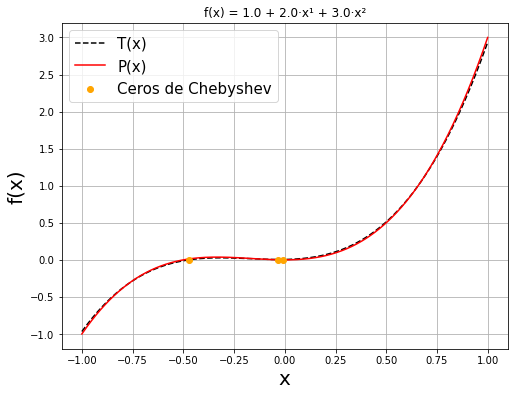

In [10]:
# Probamos y graficamos para un polinomio en particular.
#Ejemplo para escribir un polinomio
coef = np.array([1,2,3])
p = np.polynomial.Polynomial(coef)
print(p)

P_coef = np.array([0,0,1, 2])
P = np.polynomial.Polynomial(P_coef)
T_coef = proyectar(P_coef)
T = np.polynomial.chebyshev.Chebyshev(T_coef)

T_ceros = Raices(T_coef)
fig = plt.figure(figsize = (8,6))

x = np.linspace(-1,1, 1000)
plt.plot(x,T(x), '--', label = "T(x)", c = "black")
plt.plot(x,P(x), label = "P(x)", c = "red")
plt.scatter(T_ceros, T_ceros*0, c = "orange", zorder = 20, label = "Ceros de Chebyshev")
plt.title("f(x) = " + str(p))
plt.ylabel("f(x)", fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.grid()
plt.legend(fontsize = 15)

Por otro lado, proyectar no es la única manera de obtener la representación de Chebyshev, también es posible construir una matriz de cambio de base.

### 2.2 Matriz de Cambio de Base
Dada un polinomio $f(x)$ para $x \in [a, \, b]$ la expresamos como:

$$
f_{N} \equiv  \sum_{j = 0}^{N} a_j T_j (y) = \sum_{j=0}^{N} b_j y^j , \quad \quad y(x) \in [-1, \, 1] 
$$
donde 
$$
y \equiv \frac{2x - (b+a)}{b-a} 
$$
En particular, disminuimos a la mitad el costo de transformar de $\{ a_j \}$ a $\{ b_j \}$ al estudiar por separado los coeficientes pares e impares, donde definimos dos matrices de cambio de base:
$$
b_{even} = Q^{even} a_{even} \quad \quad \quad \quad b_{odd} = Q^{odd} a_{odd}
$$

Donde los elementos de las matrices son obtenidos de manera recursiva al utilizar la estrucutra de los polinomios de Chebyshev:

$$
Q_{11}^{even} = 1, \quad Q_{jj}^{even} = 2^{2j -3}, \quad Q_{j-k, \,j}^{even} = \left [ - \frac{(2j-2k)(2j-2k-1)}{2k(4j-2k-4)}Q_{j-k+1, j}^{even}\right ]
$$

$$
Q_{11}^{odd} = 2^{2j-3}, \quad Q_{j-k, \,j}^{odd} = \left [ - \frac{(2j-2k +1)(j-k)}{k(4j-2k-2)}Q_{j-k+1, j}^{odd}\right ]
$$

In [11]:
# Definimos una función que nos arroja la matriz de cambio de base dada la estructura anterior.
def change_basis_matrix(n):

    Q_even = np.zeros((n, n))
    Q_odd = np.zeros((n, n))
    Q_even[0,0] = 1
    Q_odd[0,0] = 1

    for i in range(1, n):
        Q_even[i, i] = 2**(2*(i+1) -3)
        Q_odd[i, i] = 2**(2*(i+1) -2)

    for j in range(1,n):
        for k in range(1, j+1, 1):
            Q_even[j-k, j] = np.round(- ((2*(j+1) -2*k)*(2*(j+1) - 2*k -1)*Q_even[j-k+1, j])/(2*k*(4*(j+1)-2*k -4)))
            Q_odd[j-k, j] = np.round(- ((2*(j+1) -2*k +1)*(j+1 - k)*Q_odd[j-k+1, j])/(k*(4*(j+1) -2*k -2)))

    return Q_even, Q_odd

# Obtenemos el vector a a partir del vector b utilizando el inverso de la matriz de cambio de base.
def get_a(b):
    b_even = b[0::2]
    b_odd = b[1::2]
    Qe, Qo = change_basis_matrix(len(b_even))
    a_even = np.linalg.inv(Qe) @ b_even
    a_odd = np.linalg.inv(Qo)[0:len(b_odd), 0:len(b_odd)]  @ b_odd

    a = []
    for i in range(len(b_even)):
        a.append(a_even[i])
        try:
            a.append(a_odd[i])
        except:
            None

    return a

# Función que nos arroja la expansión en base de chebysheve a partir de una expansión en base de monomios.
def get_cheby(a):
    function = 0
    x = sym.Symbol('x',Real=True)
    for i in range(len(a)):
        function += a[i]*sym.functions.special.polynomials.chebyshevt(i, x)

    return  sym.Function('Fn')(function),  sym.lambdify([x],function,'numpy')

In [12]:
#Probamos para un polinomio arbitrario
x = sym.Symbol('x',Real=True)
b =  [random.randint(0,20) for i in range(20)]
a = get_a(b)
cheby_f, f_eval = get_cheby(a)
print(b[::-1])
print(cheby_f)

[1, 10, 10, 18, 20, 1, 18, 2, 18, 15, 20, 4, 9, 7, 0, 6, 17, 4, 0, 16]
Fn(1.0*x**19 + 10.0*x**18 + 10.0*x**17 + 18.0*x**16 + 20.0*x**15 + 1.0*x**14 + 18.0*x**13 + 2.0*x**12 + 18.0*x**11 + 15.0*x**10 + 20.0*x**9 + 4.0*x**8 + 9.0*x**7 + 7.0*x**6 + 6.0*x**4 + 17.0*x**3 + 4.0*x**2 + 16.0)


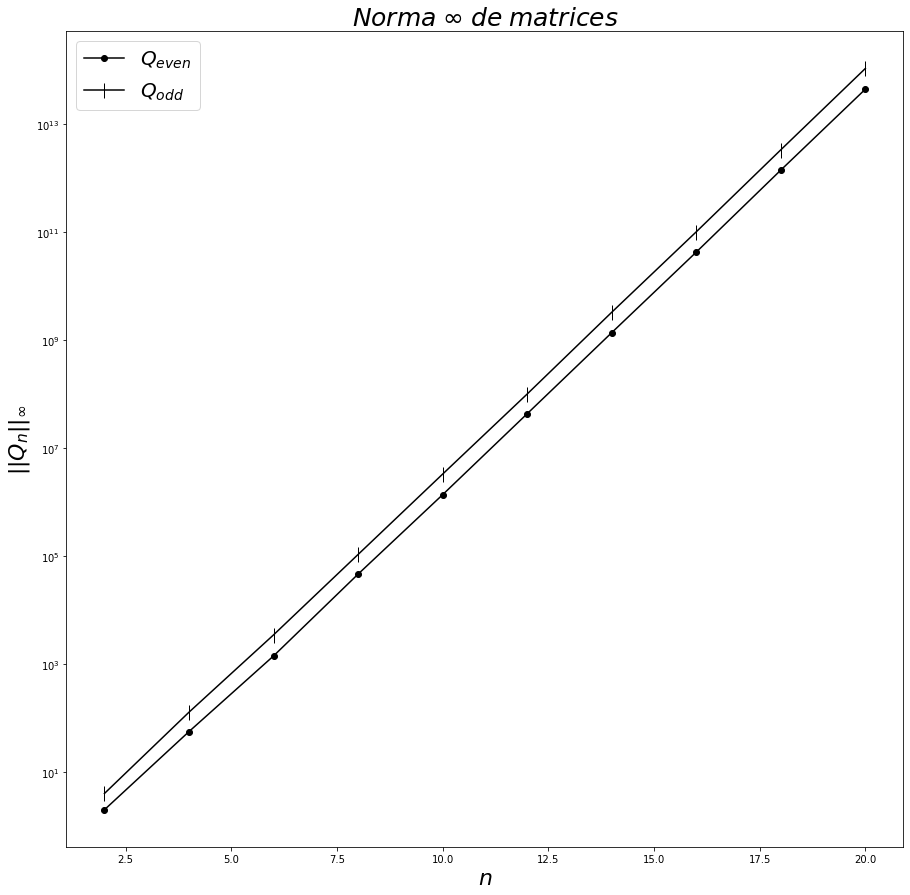

In [13]:
matrix_size = np.arange(2, 22, 2)
matrix_norm = []
for n in matrix_size:
    Qe, Qo = change_basis_matrix(n)
    matrix_norm.append([np.max(np.sum(abs(Qe), axis=1)), np.max(np.sum(abs(Qo), axis=1))])
matrix_norm = np.array(matrix_norm)

fig = plt.figure(figsize = (15, 15))

plt.title("$Norma \; \infty \; de \; matrices$", size  = 25)
plt.xlabel("$n$", size =22)
plt.ylabel("$|| Q_n||_\infty $", size =22)
plt.plot(matrix_size, matrix_norm[:,0], marker = 'o', color = 'k', label = "$Q_{even}$")
plt.plot(matrix_size, matrix_norm[:,1], marker = '|', ms = 15, color = 'k', label = "$Q_{odd}$")
plt.yscale('log')
plt.legend(loc = 'best', fontsize = 20)

### ¿Qué sucede si queremos calcular las raíces de cualquier función (no necesariamente un polinomio)?

Es necesario interpolar la función respecto a la base de Chebyshev, así se tendrá una aproximación con la que se pueden calcular las raíces.

## 3. Interpolación
 El siguiente problema que surge es, ¿cómo calcular la expansión de Chebyshev para una función arbitraria $f$?. Para solucionar esto, al recordar la relación de ortogonalidad, es natural pensar en realizar una interpolación. En esta, $f(x)$ debe evaluarse en un conjunto de puntos discretos en el intervalo objetivo (nodos de Chebyshev):
    $$
        x_j = \frac{b-a}{2}\cos{ \left ( (j +1/2) \pi /(n+1) \right )} + \frac{b+a}{2} 
    $$
    Luego, los coeficientes de la expansión \ref{ChebyExpansion} estarán dados por la multiplicación del vector que contiene el valor de $f$ evaluada en estos puntos y una matriz cuyas entradas son simples funciones trigonométricas:
    $$
        a_k = \frac{2}{n+1}\sum_{j= 0}^{n}f(x_j)\cos{ \left ( (j +1/2) \pi /(n+1) \right )} 
    $$

In [14]:
#Interpolación de grado N
def chebyshev_interpolation(f, N, a, b):

    x_k = np.array([((b-a)/2)*np.cos(np.pi*(k +1/2)/(N+1)) + ((b+a)/2) for k in range(N+1)])
    f_k = f(x_k)

    I = np.zeros((N+1, N+1))

    for j in range(N+1):
        for k in range(N+1):
            I[j, k] = (1/(N+1))*np.cos(j*np.pi*(k +1/2)/(N+1))

    a = I @ f_k

    a[1:] *=2
    function = 0
    x = sym.Symbol('x',Real=True)
    for j in range(N+1):
        function += a[j]*sym.functions.special.polynomials.chebyshevt(j, x)

    f_interpolated = sym.lambdify([x],function,'numpy')
    
    return f_interpolated, a  


In [15]:
#Interpolación de grado N
def coef_p(i, N):
    if i == 0 or i == N:
        return 2
    else:
        return 1

def chebyshev_interpolation(f, N, a, b):

    x_k = np.array([((b-a)/2)*np.cos(np.pi*(k)/(N)) + ((b+a)/2) for k in range(N+1)])
    f_k = f(x_k)

    I = np.zeros((N+1, N+1))

    for j in range(N+1):
        for k in range(N+1):
            I[j, k] = (2/(coef_p(j, N)*coef_p(k, N)*N))*np.cos(j*np.pi*(k)/(N))

    a = I @ f_k
    function = 0
    x = sym.Symbol('x',Real=True)
    for j in range(N+1):
        function += a[j]*sym.functions.special.polynomials.chebyshevt(j, x)

    f_interpolated = sym.lambdify([x],function,'numpy')
    
    return f_interpolated, a  


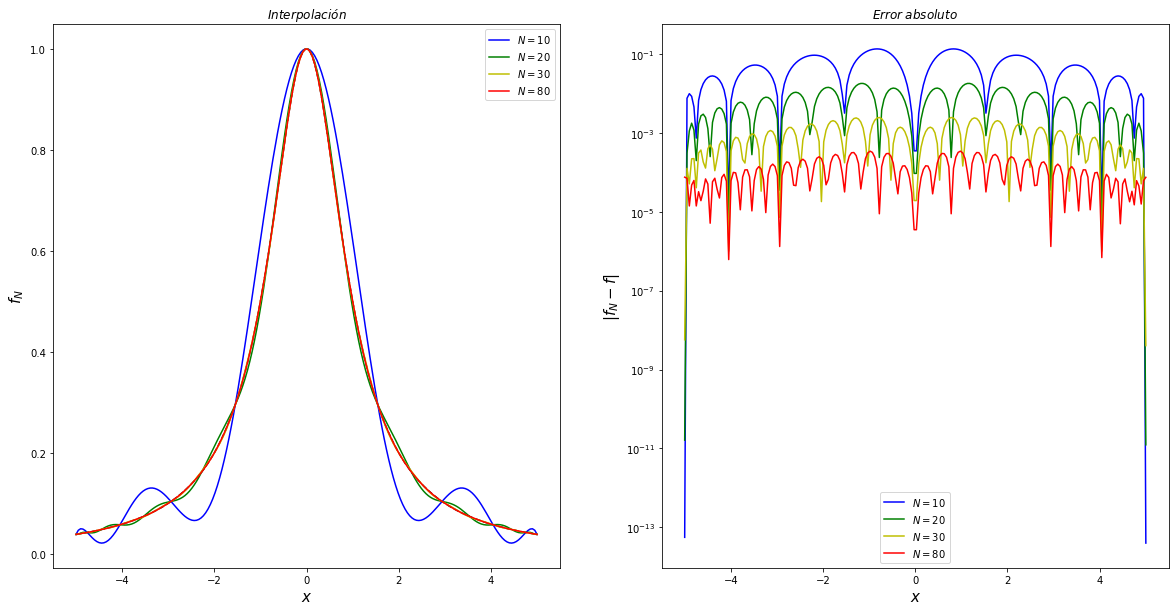

In [16]:
b, a = 5, -5
x_test = np.linspace(a, b, 200)
f = lambda x: 1/(1+x**2)
fig = plt.figure( figsize = (20, 10))
plt.axis('off')

ax1= fig.add_subplot(1, 2, 1)
ax1.set_title("$Interpolación$")
ax1.set_xlabel("$x$", fontsize = 15)
ax1.set_ylabel("$f_N$", fontsize = 15)
ax2= fig.add_subplot(1, 2, 2)
ax2.set_yscale('log')
ax2.set_title("$Error \; absoluto$")
ax2.set_xlabel("$x$", fontsize = 15)
ax2.set_ylabel("$|f_N -f|$", fontsize = 15)

ax1.plot(x_test, f(x_test), c = 'k', ls = '--')

test = chebyshev_interpolation(f, 10, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'b', label = "$N = 10$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'b', label = "$N = 10$")


test = chebyshev_interpolation(f, 20, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'g', label = "$N = 20$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'g', label = "$N = 20$")


test = chebyshev_interpolation(f, 30, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'y', label = "$N = 30$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'y', label = "$N = 30$")

test = chebyshev_interpolation(f, 40, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'r', label = "$N = 80$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'r', label = "$N = 80$")

ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

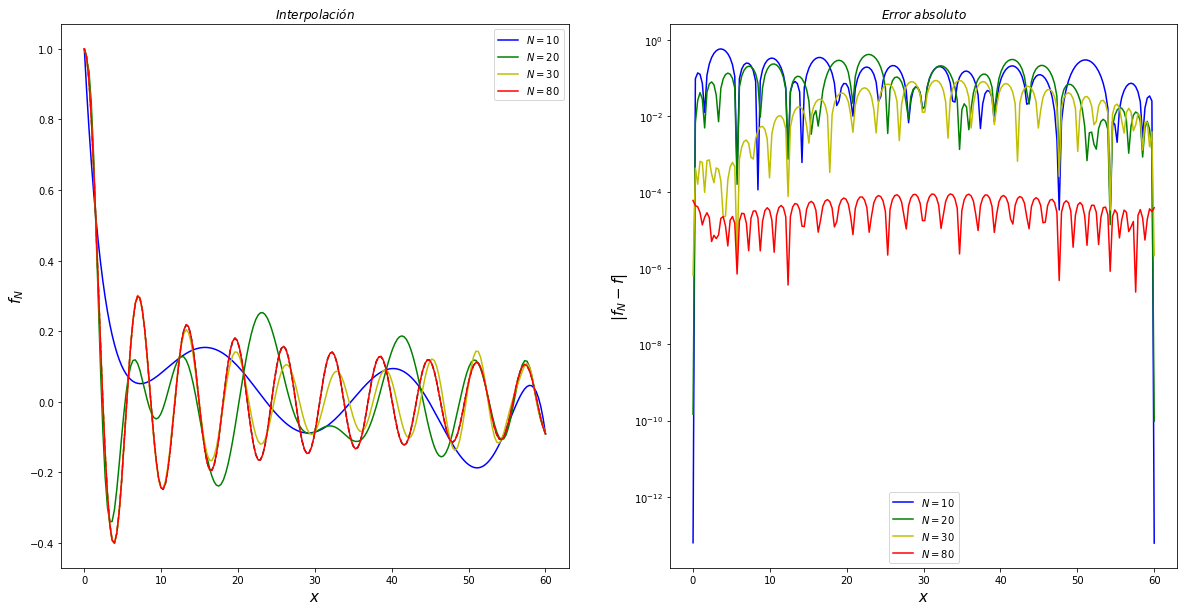

In [17]:
b, a = 0, 60
x_test = np.linspace(a, b, 200)
f = lambda x: scipy.special.jv(0, x)
fig = plt.figure( figsize = (20, 10))
plt.axis('off')
ax1= fig.add_subplot(1, 2, 1)
ax1.set_title("$Interpolación$")
ax1.set_xlabel("$x$", fontsize = 15)
ax1.set_ylabel("$f_N$", fontsize = 15)
ax2= fig.add_subplot(1, 2, 2)
ax2.set_yscale('log')
ax2.set_title("$Error \; absoluto$")
ax2.set_xlabel("$x$", fontsize = 15)
ax2.set_ylabel("$|f_N -f|$", fontsize = 15)

ax1.plot(x_test, f(x_test), c = 'k', ls = '--')

test = chebyshev_interpolation(f, 10, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'b', label = "$N = 10$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'b', label = "$N = 10$")


test = chebyshev_interpolation(f, 20, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'g', label = "$N = 20$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'g', label = "$N = 20$")


test = chebyshev_interpolation(f, 30, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'y', label = "$N = 30$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'y', label = "$N = 30$")

test = chebyshev_interpolation(f, 40, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'r', label = "$N = 80$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'r', label = "$N = 80$")

ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

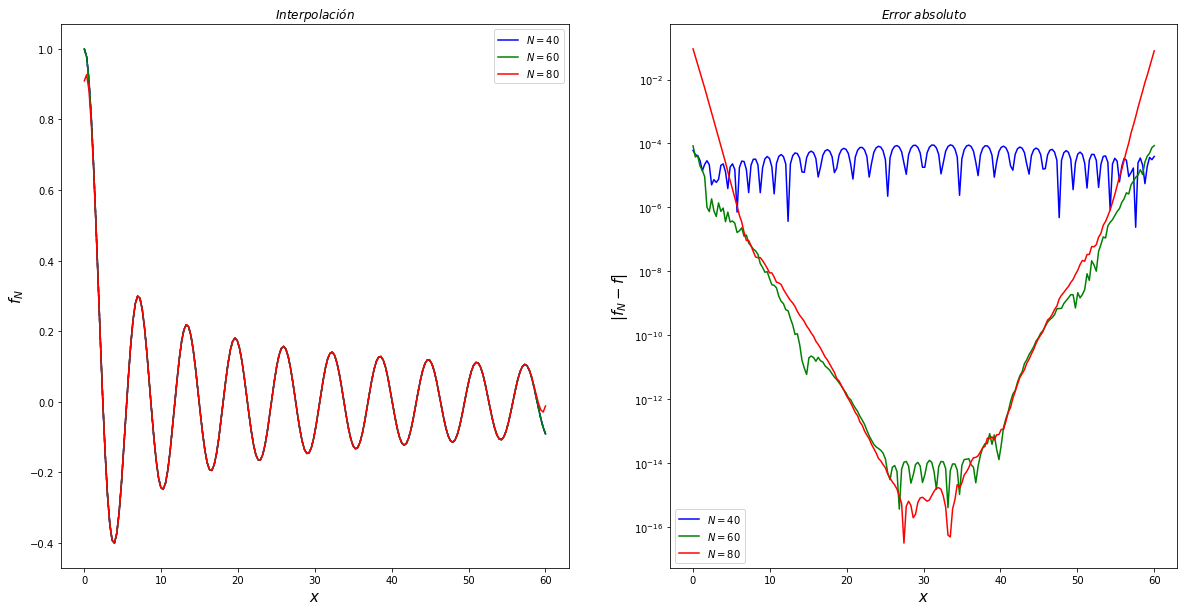

In [18]:
b, a = 0, 60
x_test = np.linspace(a, b, 200)
f = lambda x: scipy.special.jv(0, x)
fig = plt.figure( figsize = (20, 10))
plt.axis('off')

ax1= fig.add_subplot(1, 2, 1)
ax1.set_title("$Interpolación$")
ax1.set_xlabel("$x$", fontsize = 15)
ax1.set_ylabel("$f_N$", fontsize = 15)
ax2= fig.add_subplot(1, 2, 2)
ax2.set_yscale('log')
ax2.set_title("$Error \; absoluto$")
ax2.set_xlabel("$x$", fontsize = 15)
ax2.set_ylabel("$|f_N -f|$", fontsize = 15)

ax1.plot(x_test, f(x_test), c = 'k', ls = '--')

test = chebyshev_interpolation(f, 40, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'b', label = "$N = 40$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'b', label = "$N = 40$")


test = chebyshev_interpolation(f, 60, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'g', label = "$N = 60$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'g', label = "$N = 60$")

test = chebyshev_interpolation(f, 80, a, b)[0]
ax1.plot(x_test, test((2*x_test -(b+a))/(b-a)), c = 'r', label = "$N = 80$")
ax2.plot(x_test, np.abs(test((2*x_test -(b+a))/(b-a))-f(x_test)), c = 'r', label = "$N = 80$")

ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

## 4. Ejemplo de mal condicionamiento: Raíces del Polínomio de Wilkinson.

Aquí vamos a replicar la gráfica de las raíces del polínomio de Wilkinson en el plano complejo. Para esto es necesario calcular los valores propios utilizando el método de python ya que la iteración QR solo permite calcular las raíces reales.

In [19]:
def P_Wilkinson():
    global epsilon
    pw = np.polynomial.Polynomial(np.array([1,0]))
    for i in range(1,21):
        p = np.polynomial.Polynomial(np.array([0,1]))
        p_i = p - i
        pw = pw*p_i
    return pw


In [20]:
epsilon = 0.
a = P_Wilkinson()
a_coef = a.coef

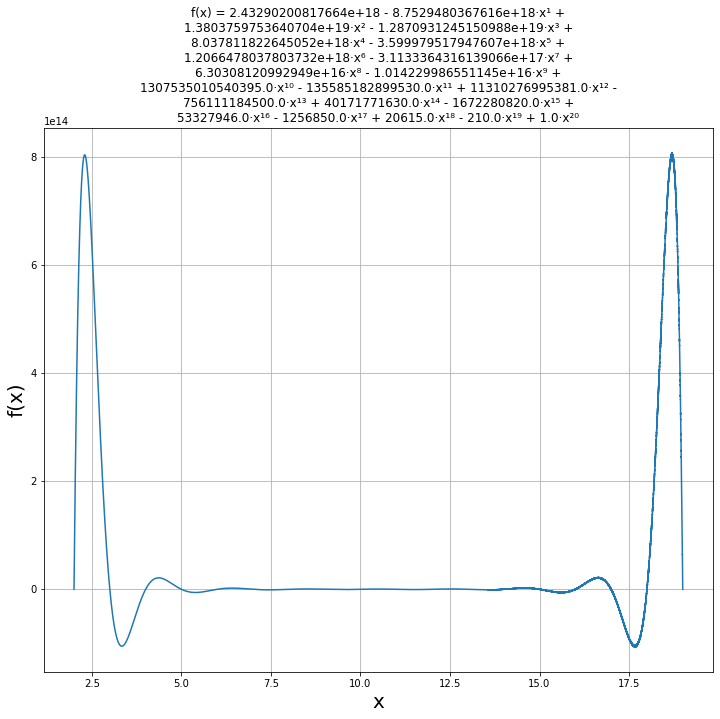

In [21]:
fig = plt.figure(figsize = (12,10))

x = np.linspace(2,19, 100000)
plt.plot(x, a(x))
plt.title("f(x) = " + str(a))
plt.ylabel("f(x)", fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.grid()


In [22]:
def epsilon(epsilon):
    perturbacion = np.polynomial.Polynomial(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))

    return P_Wilkinson() + epsilon*perturbacion

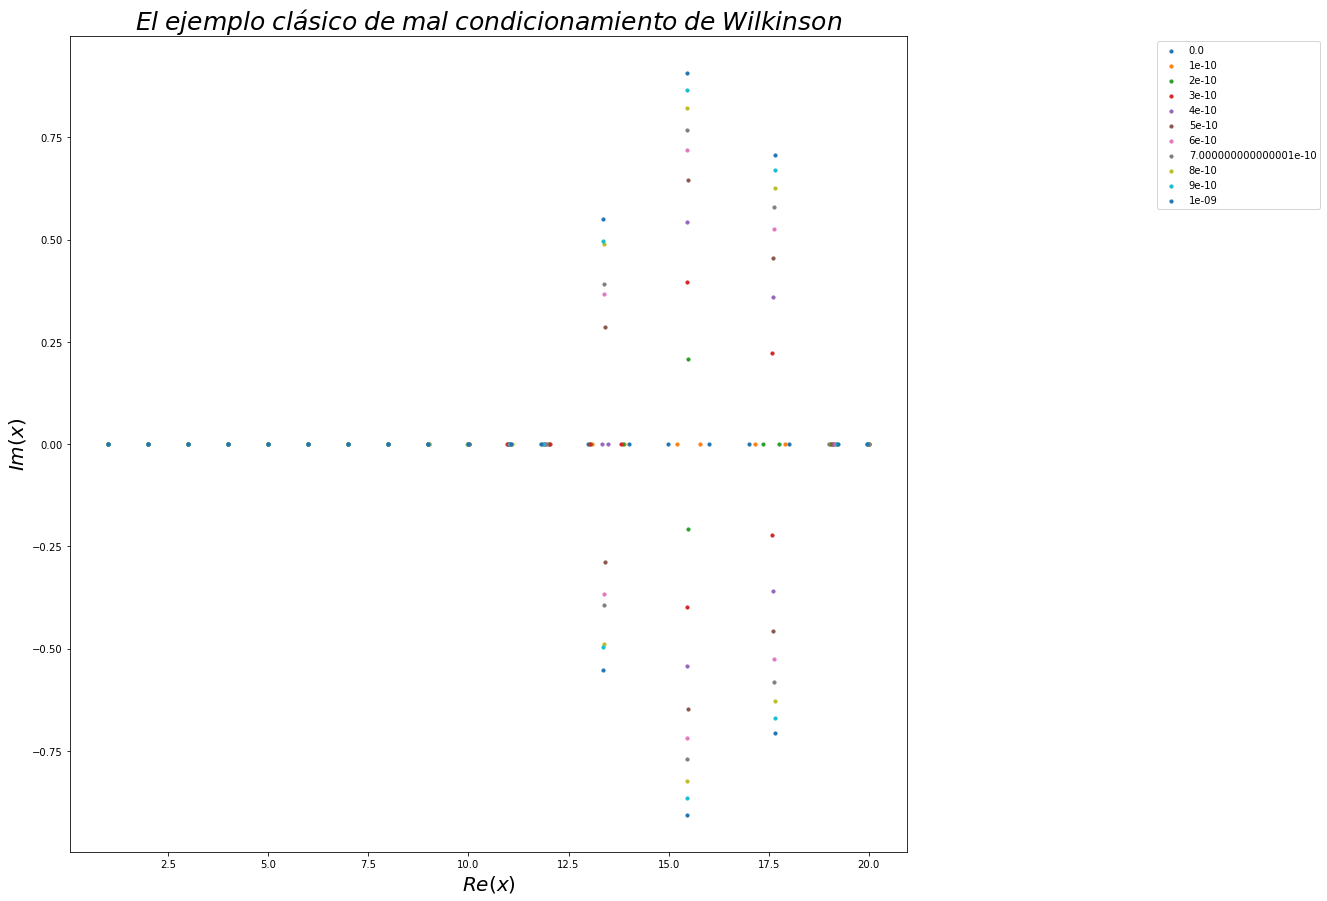

In [23]:
fig = plt.figure(figsize = (15,15))

ep = np.array([0,1,2,3,4,5,6,7,8,9,10])*(10**(-10))

for i in range(len(ep)):
    PW = epsilon(ep[i])
    PW_coef = PW.coef
    Chevyshev_coef = get_a(np.append(PW_coef, 0))[:-1]

    ceros = Raices_Python(Chevyshev_coef)

    plt.scatter(np.real(ceros), np.imag(ceros), label = str(ep[i]), s = 10)
    plt.legend(bbox_to_anchor=(0.5,0,1,1))

plt.xlabel("$Re(x)$", fontsize = 20)
plt.ylabel("$Im(x)$", fontsize = 20)
plt.title("$El \; ejemplo \; clásico \; de \; mal \; condicionamiento \; de \; Wilkinson$", fontsize = 25)
plt.show()

In [24]:
def normal_random():
    coef = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    k = 16
    coef[k] = 1
    perturbacion = np.polynomial.Polynomial(coef)
    r= np.random.normal(10**(-10) , 1)
    return P_Wilkinson() + r*perturbacion

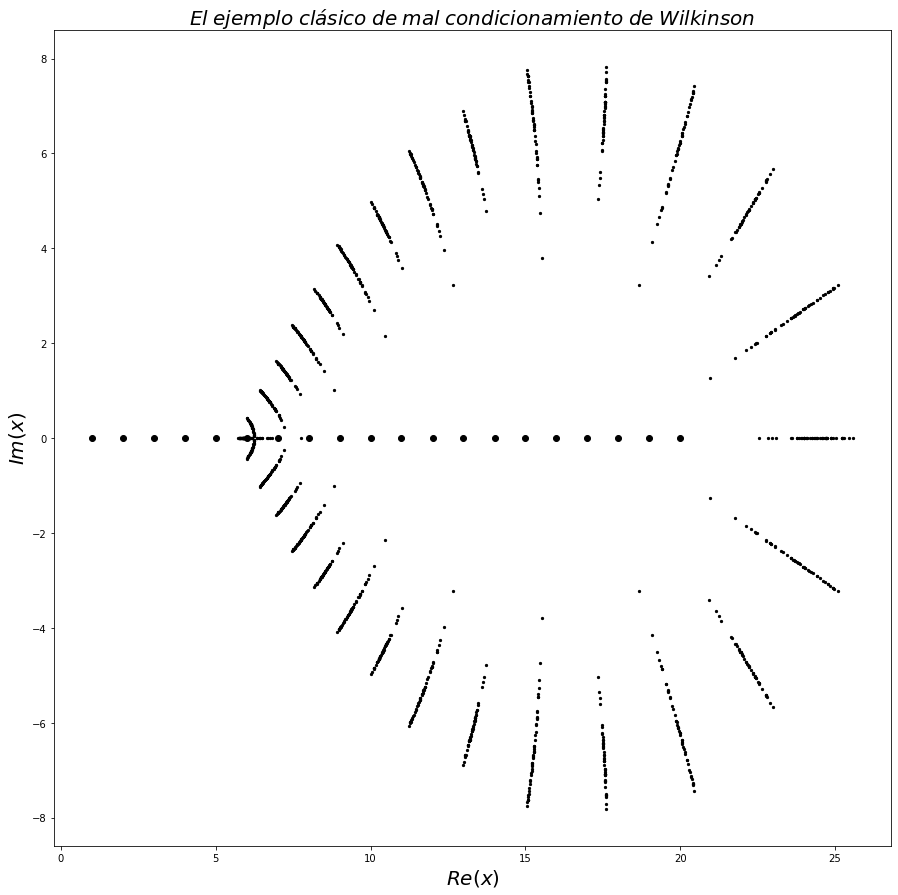

In [25]:
fig = plt.figure(figsize = (15,15))

ceros = Raices_Python(get_a(np.append(a_coef, 0))[:-1])
plt.scatter(np.real(ceros), np.imag(ceros), c = 'k')


for i in range(100):
    PW = normal_random()
    PW_coef = PW.coef

    Chevyshev_coef = get_a(np.append(PW_coef, 0))[:-1]
    ceros = Raices_Python(Chevyshev_coef)
    plt.scatter(np.real(ceros), np.imag(ceros), s = 5, c = 'k')

plt.xlabel("$Re(x)$", fontsize = 20)
plt.ylabel("$Im(x)$", fontsize = 20)
plt.title("$El \; ejemplo \; clásico \; de \; mal \; condicionamiento \; de \; Wilkinson$", fontsize = 20)
plt.show()

## 5. Experimentos numéricos de condicionamiento
Primero, definimos el polinomio $\tilde{p}(x)$. Cabe resaltar, que como nuestro método no está optimizado, encontramos los valores propios directamente con el método implementado en python.

In [26]:
# Polinomio perturbado 
def p_test(roots):
    pw = np.polynomial.Polynomial(np.array([1,0]))
    for i in range(len(roots)):
        p = np.polynomial.Polynomial(np.array([0,1]))
        p_i = p - roots[i]
        pw = pw*p_i
    return pw


**Primer experimento numérico**: Dependencia de error regresivo con respecto a norma del polinomio original.

In [27]:
x1, y1 = [], []
for k in range(2, 11):
    max_error= 0
    for _ in range(1000):
        a = np.random.normal(size = 11)
        a = (10**k)*a/(np.linalg.norm(a, 2))
        raices = Raices_Python(a)
        p_ = p_test(raices)
        b_ = p_.convert().coef
        a_ = get_a(b_)
        e = np.linalg.norm(a_ - a, 2)
        if max_error < e:
            max_error = e
    x1.append(10**k)
    y1.append(max_error)

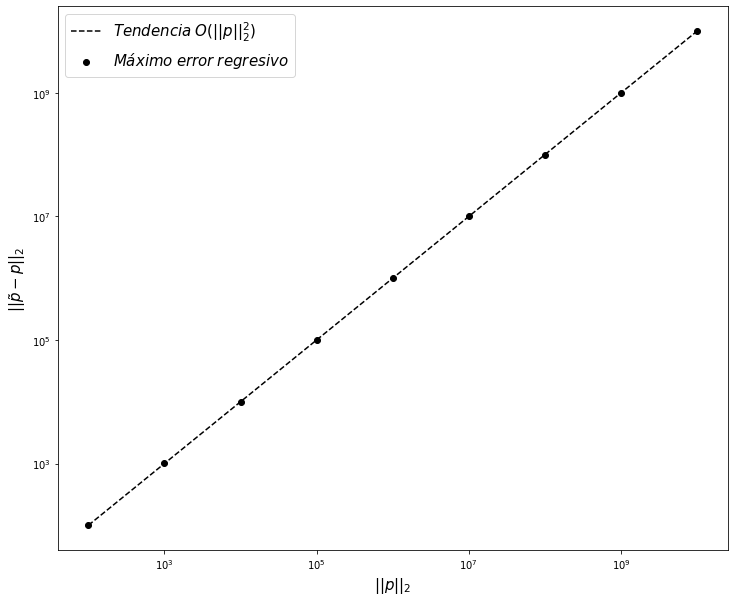

In [28]:
fig = plt.figure(figsize = (12,10))

plt.scatter(x1, y1, c = "k", zorder = 20, label = "$Máximo \; error \; regresivo $")
plt.plot(x1, x1, c = 'k', ls = '--', label = '$Tendencia \; O(||p||_2^2) $')
plt.ylabel(r"$||\tilde{p} - p||_2 $", fontsize = 15)
plt.xlabel("$||p||_2 $", fontsize = 15)

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)

**Segundo experimento numérico**: Dependencia de error regresivo con respecto a grado del polinomio original.

In [29]:
x, y = [], []
for n in range(10, 201, 2):
    max_error = 0
    for _ in range(100):
        a = np.random.normal(size = n)
        a = np.append(a, 1)
        a = a/(np.linalg.norm(a, 2))
        raices = Raices_Python(a)
        p_ = p_test(raices)
        b_ = p_.convert().coef
        a_ = get_a(b_)
        if max_error < np.linalg.norm(a_ - a, 2):
            max_error = np.linalg.norm(a_ - a, 2)
    x.append(n)
    y.append(max_error)

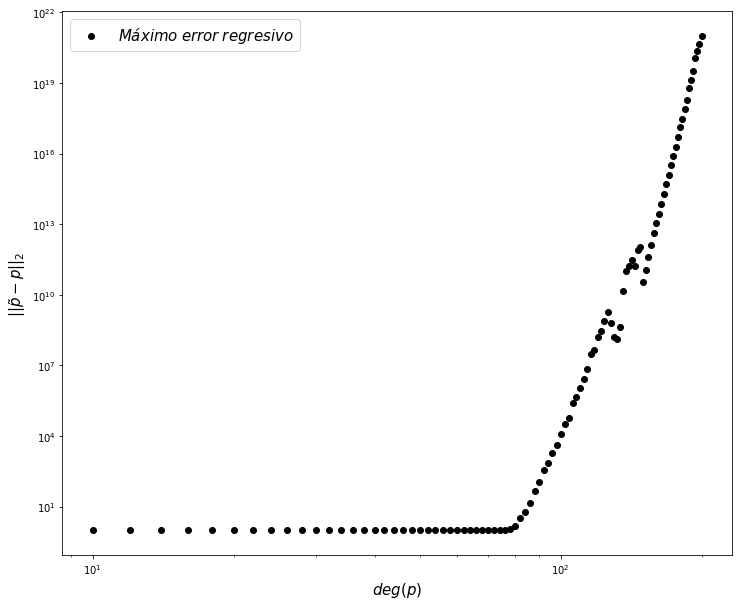

In [30]:
fig = plt.figure(figsize = (12,10))
x = np.array(x)
plt.scatter(x, y, c = "k", zorder = 20,  label = "$Máximo \; error \; regresivo $")
plt.ylabel(r"$||\tilde{p} - p||_2 $", fontsize = 15)
plt.xlabel("$deg(p) $", fontsize = 15)
plt.legend(fontsize = 15)
plt.xscale('log')
plt.yscale('log')

## 6. Fenómenos interesantes

### Convergencia a descomposición real de Schur
Retomando lo implementado al inicio

In [31]:
np.set_printoptions(threshold=np.inf, linewidth=200)

In [32]:
# Queremos ver a qué converge la itertación QR. PArticularmente, utilizamos la factorización QR implementada en Python
def V_Propios(A, N = 100000):
    for _ in range(N):
        Q, R = np.linalg.qr(A)
        A = R@Q
    return A

In [33]:
# Tomamos una matriz arbitraria
A = np.array([[2., 3., 1., 0.5, 4.], 
             [4., 5., 7., 0.1, 1.0], 
             [5., 3., 6., 19.2, 9.],
             [1., 4., 1., 4., 7.],
             [3., 1., 6., 2., 6.]])
print(A)

R = V_Propios(A, 100)
print(R)

[[ 2.   3.   1.   0.5  4. ]
 [ 4.   5.   7.   0.1  1. ]
 [ 5.   3.   6.  19.2  9. ]
 [ 1.   4.   1.   4.   7. ]
 [ 3.   1.   6.   2.   6. ]]
[[ 2.13589437e+001 -6.10952092e+000  9.81948514e+000  4.81835736e+000 -2.86010700e+000]
 [ 4.81014068e-048 -2.14099422e+000  8.72020352e+000  3.10024868e+000 -6.59509565e+000]
 [-1.34371049e-049 -5.12404323e+000 -1.82092680e+000  1.99229416e+000 -8.43218374e-001]
 [ 1.51196522e-068 -3.30729594e-021  2.36546741e-020  4.34496142e+000 -3.23165998e-001]
 [ 9.80093503e-122 -1.27813942e-073  1.95148380e-073  2.54330468e-053  1.25801593e+000]]


Identificamos una convergencia a una matriz diagonal por bloques. Para verificar si esta es la descomposición real de Schur vemos a qué correspoden las matrices 2x2 de la diagonal.

In [34]:
# Misma matriz y calculamos su polinomio característico
M = sym.Matrix([[2., 3., 1., 0.5, 4.], 
             [4., 5., 7., 0.1, 1.0], 
             [5., 3., 6., 19.2, 9.],
             [1., 4., 1., 4., 7.],
             [3., 1., 6., 2., 6.]])
f_prueba = M.charpoly('x')
print(f_prueba)

PurePoly(1.0*x**5 - 23.0*x**4 + 66.9*x**3 - 930.8*x**2 + 5616.9*x - 5671.79999999997, x, domain='RR')


In [35]:
#Ahora, implementamos un recorrido iterativo a lo largo de la diagonal de la matriz de la iteración QR
Roots = []
i = 0
while i < len(R):
    test = f_prueba(R[i, i])
    if np.abs(test) <= 1e-8:
        Roots.append([R[i, i], f_prueba(R[i, i])])
        i+= 1
    else:
        a, b, c, d = R[i, i], R[i, i+1], R[i+1, i], R[i+1, i+1]
        r1, r2 = ((a+d) + np.sqrt(((a+d)**2) - 4*(a*d -b*c)+ 0j) )/2,  ((a+d) - np.sqrt(((a+d)**2) - 4*(a*d -b*c) + 0j))/2
        Roots.append([r1, f_prueba(r1)])
        Roots.append([r2, f_prueba(r2)])
        i += 2
Roots = np.array(Roots)
# Verificamos si concuerdan con las calculadas con métodos de python
roots = np.linalg.eig(R)[0]
print(Roots[:,0])
print(roots)

[21.358943679434017 (-1.9809605111405522+6.682595976765392j) (-1.9809605111405522-6.682595976765392j) 4.344961416647903 1.2580159261991808]
[21.35894368+0.j         -1.98096051+6.68259598j -1.98096051-6.68259598j  4.34496142+0.j          1.25801593+0.j        ]


Así, reimplementamos nuestro método para hallar valores propios al tomar en cuenta el anterior hallazgo.

In [36]:
def qr_roots(f_prueba, coefs, tol):
    R = V_Propios(C_Matrix(coefs), 1000)
    Roots = []
    i = 0
    while i < len(R):
        test = f_prueba(R[i, i])
        if np.abs(test) <= tol:
            Roots.append(R[i, i])
            i+= 1
        else:
            a, b, c, d = R[i, i], R[i, i+1], R[i+1, i], R[i+1, i+1]
            r1, r2 = ((a+d) + np.sqrt(((a+d)**2) - 4*(a*d -b*c)+ 0j) )/2,  ((a+d) - np.sqrt(((a+d)**2) - 4*(a*d -b*c) + 0j))/2
            Roots.append(r1)
            Roots.append(r2)
            i += 2
    return(np.array(Roots))

[-3.67799348+0.j         -0.16100326+0.88867321j -0.16100326-0.88867321j]
[-3.67799348+0.j         -0.16100326+0.88867321j -0.16100326-0.88867321j]


/home/pachodp13/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


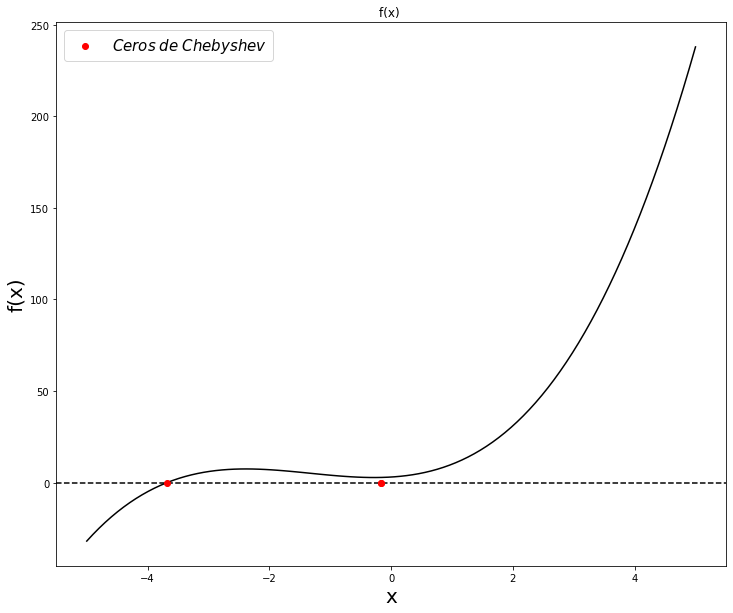

In [37]:
x = sym.Symbol('x',Real=True)
b =  [3, 2, 4, 1]
a = get_a(b)
cheby_f, f_prueba = get_cheby(a)
roots = qr_roots(f_prueba, a, 1e-8)
print(roots)
print(np.linalg.eigvals(C_Matrix(a)))

fig = plt.figure(figsize = (12,10))

x = np.linspace(-5,5,100)

plt.plot(x, f_prueba(x),  c = "black")
plt.scatter(roots, f_prueba(roots), c = "red", zorder = 20, label = "$Ceros\; de \; Chebyshev $")
plt.title("f(x) ")
plt.ylabel("f(x)", fontsize = 20)
plt.xlabel("x", fontsize = 20)
plt.axhline(y = 0, ls = '--', c = 'k')
plt.legend(fontsize = 15)

### Elipse de convergencia
Por otro lado, ¿qué sucede con todas las raíces de los polinomios interpolantes utilizados? Calculamos estas raíces directamente con un método de python, pues el implementado anteriormente no está optimizado.

In [40]:
#Cálculo de raíces usando la iteración QR 
def cheb_roots(f, a, b, N):

    coefs = chebyshev_interpolation(f, N, a, b)[1]

    roots = Raices_Python(coefs)

    return roots

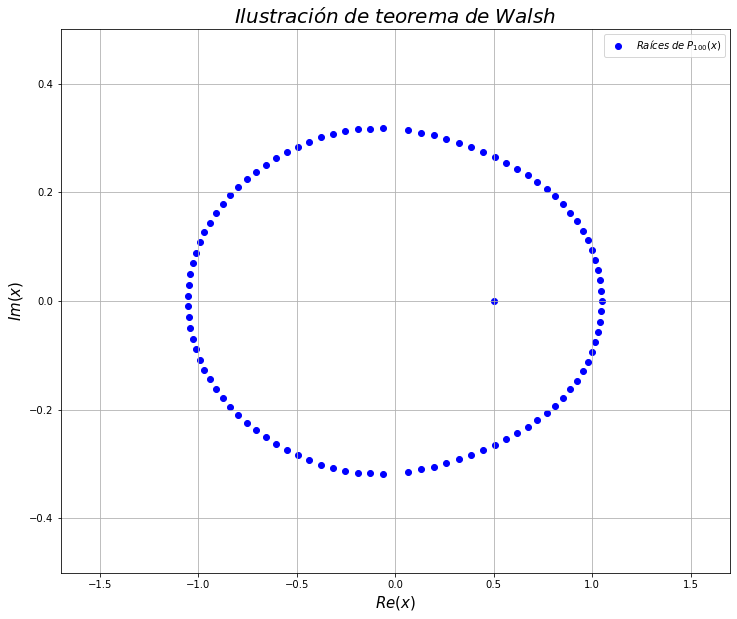

In [41]:
f = lambda x: (x-0.5)/(1+10*x**2)

ceros = cheb_roots(f, -1, 1, 100)

fig = plt.figure(figsize = (12,10))
plt.scatter(np.real(ceros), np.imag(ceros), color = 'blue', label = '$Raíces \; de \; P_{100}(x)$')
plt.xlabel("$Re(x)$", fontsize = 15)
plt.ylabel("$Im(x)$", fontsize = 15)
plt.title("$Ilustración \; de \; teorema \; de \; Walsh$", fontsize = 20)
plt.xlim(-1.7, 1.7)
plt.ylim(-0.5, 0.5)
plt.style.use('default')
plt.legend(loc = 'best')
plt.grid()
plt.show()

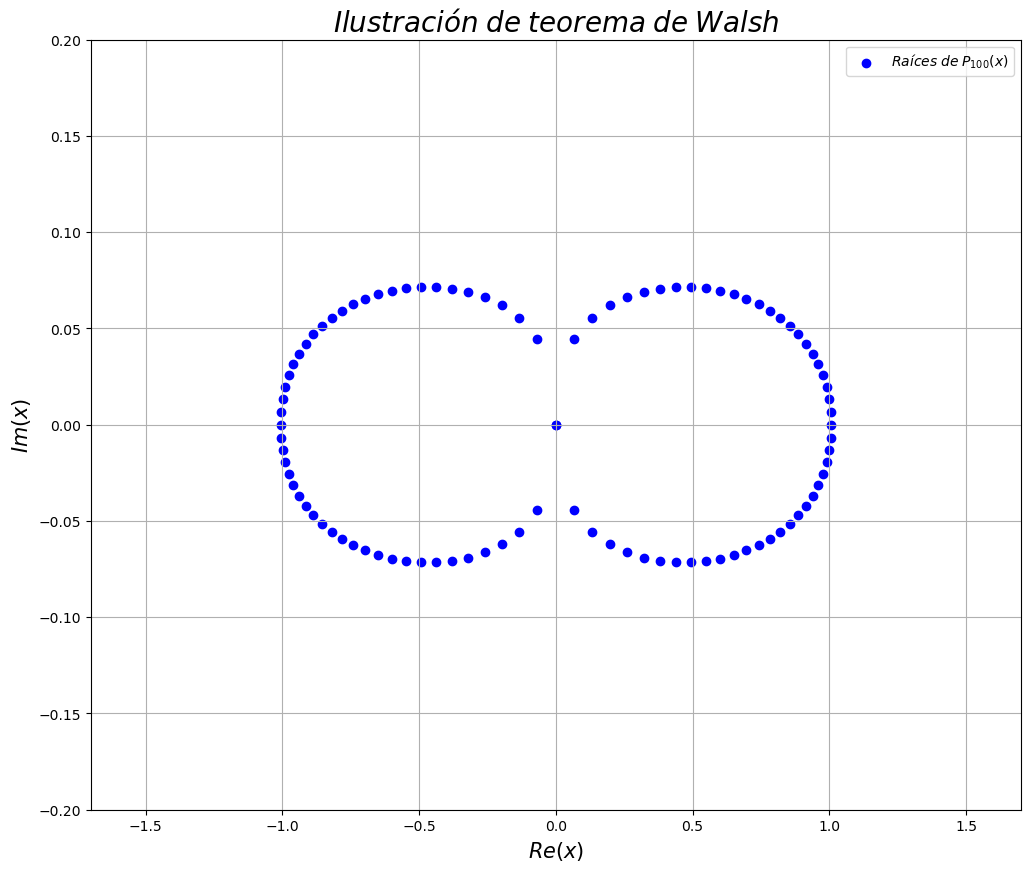

In [42]:
f = lambda x: np.abs(x)

ceros = cheb_roots(f, -1, 1, 100)

fig = plt.figure(figsize = (12,10))
plt.scatter(np.real(ceros), np.imag(ceros), color = 'blue', label = '$Raíces \; de \; P_{100}(x)$')
plt.xlabel("$Re(x)$", fontsize = 15)
plt.ylabel("$Im(x)$", fontsize = 15)
plt.title("$Ilustración \; de \; teorema \; de \; Walsh$", fontsize = 20)
plt.xlim(-1.7, 1.7)
plt.ylim(-0.2, 0.2)
plt.style.use('default')
plt.legend(loc = 'best')
plt.grid()
plt.show()

### Referencias:

[1] Arbenz, P (2018). Numerical Methods for Solving Large Scale Eigenvalue Problems Lecture Notes.

[2] Bender, C. M., Orszag, S., & Orszag, S. A. (1999). Advanced mathematical methods for scientists and engineers I: Asymptotic methods and perturbation theory (Vol. 1). Springer Science & Business Media.

[3] Boyd, J. P. (2002). Computing zeros on a real interval through Chebyshev expansion and polynomial rootfinding. SIAM Journal on Numerical Analysis, 40(5), 1666-1682.

[5] Burden, R. L., \& Faires, J. D. (2010). Numerical analysis. Cengage learning.

[5] Gil, A., Segura, J., & Temme, N. M. (2007). Numerical methods for special functions. Society for Industrial and Applied Mathematics.

[6] Good, I. J. (1961). The colleague matrix, a Chebyshev analogue of the companion matrix. The Quarterly Journal of Mathematics, 12(1), 61-68.

[/] Trefethen, L. N. (2019). Approximation Theory and Approximation Practice, Extended Edition. Society for Industrial and Applied Mathematics 

[8] Noferini, V., \& Pérez, J. (2017). Chebyshev rootfinding via computing eigenvalues of colleague matrices: when is it stable?. Mathematics of Computation, 86(306), 1741-1767.